In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

### Make a say 'HELLO' function

In [40]:
from matplotlib.image import imread
def make_hello( N = 1000, rseed = 20):
    
    # make a plot with "HELLO" text; save as png
    fig, ax = plt.subplots( figsize = (4,1) )
    fig.subplots_adjust( left = 0, bottom = 0, top = 1)
    ax.axis( 'off' )
    ax.text( 0.5, 0.4 , 'HELLO', va = 'center',ha='center', weight = 'bold', size = 85 )
    fig.savefig( '/Users/p.sfriso/Desktop/hello.png' )
    plt.close( fig )
    
    # open this PNG and draw random points from it
    data = imread( '/Users/p.sfriso/Desktop/hello.png' )[::-1, :, 0 ].T
    rng = np.random.RandomState( rseed )
    X = rng.rand(4 * N, 2)
    i, j = (X * data.shape).astype(int).T
    mask = (data[i, j] < 1)
    X = X[mask]
    X[:, 0] *= (data.shape[0] / data.shape[1])
    X = X[:N]
    
    return X[np.argsort(X[:, 0])]

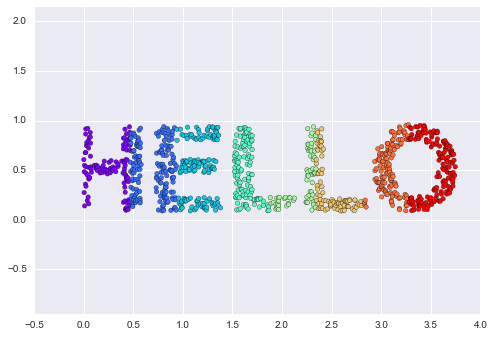

In [41]:
X = make_hello(1000)
colorize = dict( c =X[:,0], cmap = plt.cm.get_cmap( 'rainbow', 8) )
plt.scatter( X[:,0], X[:,1] , **colorize )
plt.axis( 'equal');

## Multidimensional Scaling

We first need to build a pairwise distance matrix that will contain the distance between points

In [44]:
from sklearn.metrics import pairwise_distances

In [45]:
D = pairwise_distances( X )
D.shape

(1000, 1000)

In [48]:
sum( D.diagonal() ) # property of a distance matrix

0.0

Visualization of the matrix:

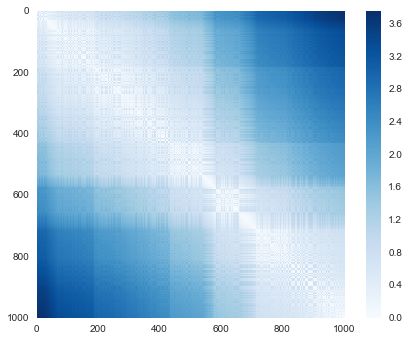

In [49]:
plt.imshow( D, zorder = 2, cmap = 'Blues', interpolation = 'nearest' )
plt.colorbar();

Multidimensional scaling algorithm aims to recover the original-dimension coordinate from the distance matrix 

In [50]:
from sklearn.manifold import MDS

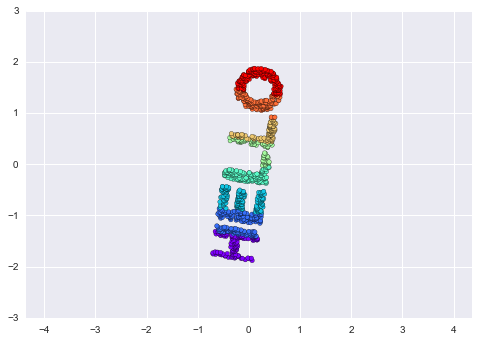

In [51]:
model = MDS( n_components=2, dissimilarity='precomputed', random_state = 1 )
out = model.fit_transform( D )
plt.scatter( out[:,0], out[:,1], **colorize )
plt.axis('equal');

## Nonlinear Manifolds

In [53]:
def make_hello_s_curve(X):
    t = (X[:, 0] - 2) * 0.75 * np.pi
    x = np.sin(t)
    y = X[:, 1]
    z = np.sign(t) * (np.cos(t) - 1)
    return np.vstack((x, y, z)).T

XS = make_hello_s_curve(X)

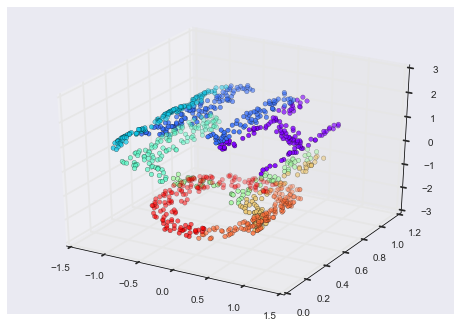

In [54]:
from mpl_toolkits import mplot3d
ax = plt.axes(projection='3d')
ax.scatter3D(XS[:, 0], XS[:, 1], XS[:, 2],
             **colorize);

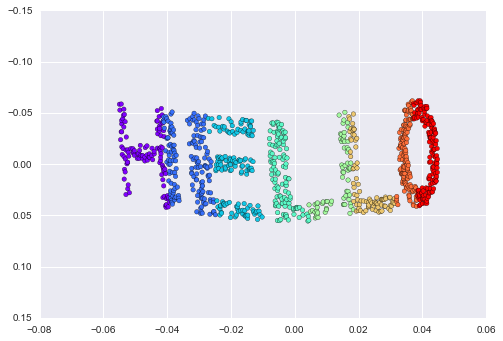

In [55]:
from sklearn.manifold import LocallyLinearEmbedding
model = LocallyLinearEmbedding(n_neighbors=100, n_components=2, method='modified',
                               eigen_solver='dense')
out = model.fit_transform(XS)

fig, ax = plt.subplots()
ax.scatter(out[:, 0], out[:, 1], **colorize)
ax.set_ylim(0.15, -0.15);

## Example: visualizing structure in digits

In [56]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata( 'MNIST original' )
mnist.data.shape

(70000, 784)

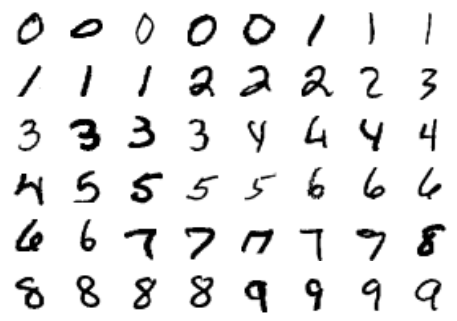

In [58]:
fig, ax = plt.subplots( 6, 8, subplot_kw = {'xticks': [], 'yticks': []} )
for i , axis in enumerate( ax.flat ):
    axis.imshow( mnist.data[1250*i].reshape(28,28) , cmap = 'gray_r')

we are going to use one third of the data for speed reasons

In [60]:
from sklearn.manifold import Isomap

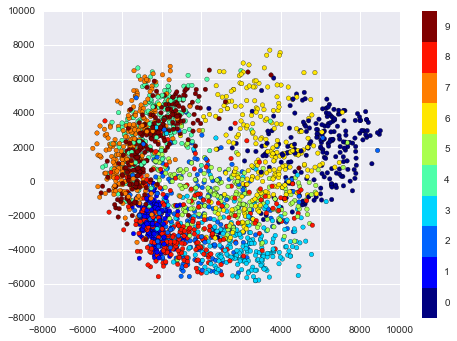

In [61]:
data = mnist.data[::30]
target = mnist.target[::30]

model = Isomap(n_components=2)
proj = model.fit_transform(data)
plt.scatter(proj[:, 0], proj[:, 1], c=target, cmap=plt.cm.get_cmap('jet', 10))
plt.colorbar(ticks=range(10))
plt.clim(-0.5, 9.5);

 too crowded, use only number 7

In [67]:
from matplotlib import offsetbox

def plot_components(data, model, images=None, ax=None,
                    thumb_frac=0.05, cmap='gray'):
    ax = ax or plt.gca()
    
    proj = model.fit_transform(data)
    ax.plot(proj[:, 0], proj[:, 1], '.k')
    
    if images is not None:
        min_dist_2 = (thumb_frac * max(proj.max(0) - proj.min(0))) ** 2
        shown_images = np.array([2 * proj.max(0)])
        for i in range(data.shape[0]):
            dist = np.sum((proj[i] - shown_images) ** 2, 1)
            if np.min(dist) < min_dist_2:
                # don't show points that are too close
                continue
            shown_images = np.vstack([shown_images, proj[i]])
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(images[i], cmap=cmap),
                                      proj[i])
            ax.add_artist(imagebox)

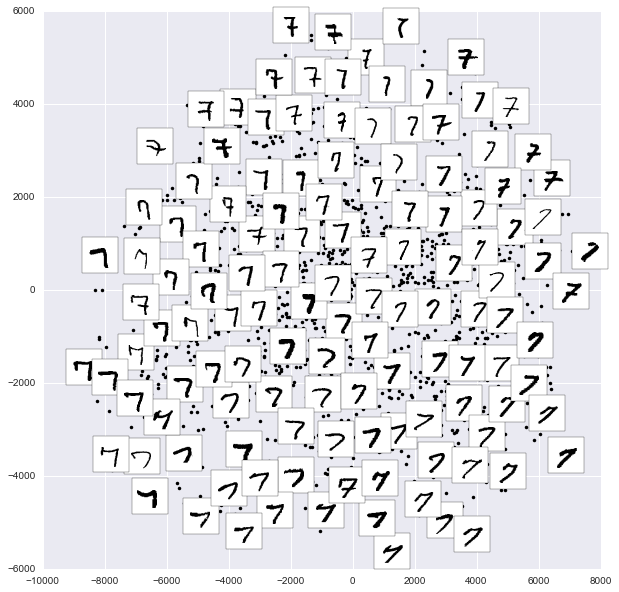

In [71]:
# Choose 1/4 of the "1" digits to project
data = mnist.data[mnist.target == 7][::4]

fig, ax = plt.subplots(figsize=(10, 10))
model = Isomap(n_neighbors=5, n_components=2, eigen_solver='dense')
plot_components(data, model, images=data.reshape((-1, 28, 28)),
                ax=ax, thumb_frac=0.05, cmap='gray_r')

The figure gives us an idea of how 7's are distributed: orientation of the 7 appears to be the dominating characteristic captured in the 2 manifold component